# Cas d'application
ce notebook est un exemple qui permet d'exéctuer les scripts

In [1]:
!where python

C:\Users\simon\micromamba\envs\pymdu\python.exe
C:\OSGeo4W\bin\python.exe


# 0. Pré-requis

### Utiliser micromamba avec python 3.11


`numba gdal qgis shapely unidecode statsmodels jaydebeapi importlib_metadata xarray numpy==1.26.4 python-gitlab h3 orjson rasterio jsonmerge ipython_genutils OSMPythonTools libpysal momepy osmnx clustergram t4gpd pysolar geocube h3pandas`

Pour le packages non accessibles, utiliser `uv pip install xxx`
t4gpd edsger suntimes

### Avoir installé Qgis et le plugin `UMEP`
https://trac.osgeo.org/osgeo4w/

In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'pymdu'))

In [3]:
import os
import pandas as pd
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
from osgeo import gdal, gdalconst
from shapely import box
import subprocess
import pymdu

input_path = os.path.join(os.getcwd(), 'example')
output_path = os.path.join(os.getcwd(), 'results')
try:
    os.mkdir(output_path)
except:pass

TEMP_PATH C:\Users\simon\AppData\Local\Temp


# I. Récupération des arbres

In [4]:
import pandas as pd
from shapely import Point
shapefile = os.path.join(input_path, 'ARBRES.shp')
sol = os.path.join(input_path, 'SOL_ESPACES VERTS.shp')
liste_point = []
liste_y = []
for geom in gpd.GeoDataFrame.from_file(shapefile).geometry:
    liste_point.append(Point(geom.coords[0]))
df = pd.DataFrame()
df['geometry'] = liste_point
gdf = gpd.GeoDataFrame(
    df, geometry=liste_point, crs="EPSG:3946"
)
gdf = gdf.to_crs(2154)
gdf['height'] = 6
gdf['type'] = 2
gdf['trunk_zone'] = 3
gdf['resolution']=11
gdf.to_file(os.path.join(input_path,'trees.shp'))

In [5]:
gdf

,geometry,height,type,trunk_zone,resolution
0,POINT Z (379497.294 6574052.012 0),6,2,3,11
1,POINT Z (379490.909 6574055.941 0),6,2,3,11
2,POINT Z (379516.18 6574098.227 0),6,2,3,11
3,POINT Z (379519.702 6574104.359 0),6,2,3,11
4,POINT Z (379523.25 6574110.727 0),6,2,3,11
...,...,...,...,...,...
112,POINT Z (379619.834 6574118.328 0),6,2,3,11
113,POINT Z (379621.655 6574121.508 0),6,2,3,11
114,POINT Z (379624.491 6574126.507 0),6,2,3,11
115,POINT Z (379626.811 6574130.338 0),6,2,3,11


# II. Construction de la couche `buildings.shp`

In [6]:
building_path = os.path.join(input_path, 'buildings.shp')
batiments_environnants = gpd.read_file(building_path).to_crs(2154)
BDTOPO_KEYS_EXCEPT_GEOM = batiments_environnants.columns[:-1]

path_bld_rdc = os.path.join(input_path, 'BATIMENT_RDC SOUSTRAIT.shp')
ecole_rdc = gpd.read_file(path_bld_rdc).to_crs(2154)
for k in BDTOPO_KEYS_EXCEPT_GEOM:
    ecole_rdc[k] = 3

path_bld_r1 = os.path.join(input_path,  'BATIMENT_R1.shp')
ecole_r1 = gpd.read_file(path_bld_r1).to_crs(2154)
for k in BDTOPO_KEYS_EXCEPT_GEOM:
    ecole_r1[k] = 6

path_bld_preau = os.path.join(input_path, 'BATIMENT_PREAU.shp')
ecole_preau = gpd.read_file(path_bld_preau).to_crs(2154)
for k in BDTOPO_KEYS_EXCEPT_GEOM:
    ecole_preau[k] = 6

joined = pd.concat([batiments_environnants, ecole_rdc, ecole_r1])

<Axes: >

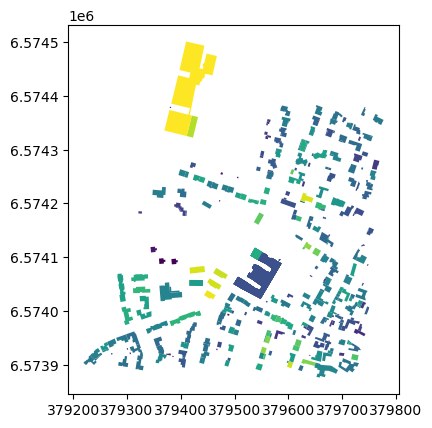

In [7]:
joined.plot(column="hauteur")

In [8]:
joined.to_file(os.path.join(input_path, 'buildings.shp'))

# III. Construction de la bbox à partir de buildings


In [9]:
joined_4326 = joined.to_crs(4326)
bbox_final = [joined_4326.envelope.bounds.minx.min(),
joined_4326.envelope.bounds.miny.min(),
joined_4326.envelope.bounds.maxx.max(),
joined_4326.envelope.bounds.maxy.max()]

In [10]:
from pymdu.GeoCore import GeoCore
geo_core = GeoCore()
geo_core.bbox = bbox_final
bbox_final

[-1.1610335200000002, 46.188812139999996, -1.15411922, 46.19434633]

<Axes: >

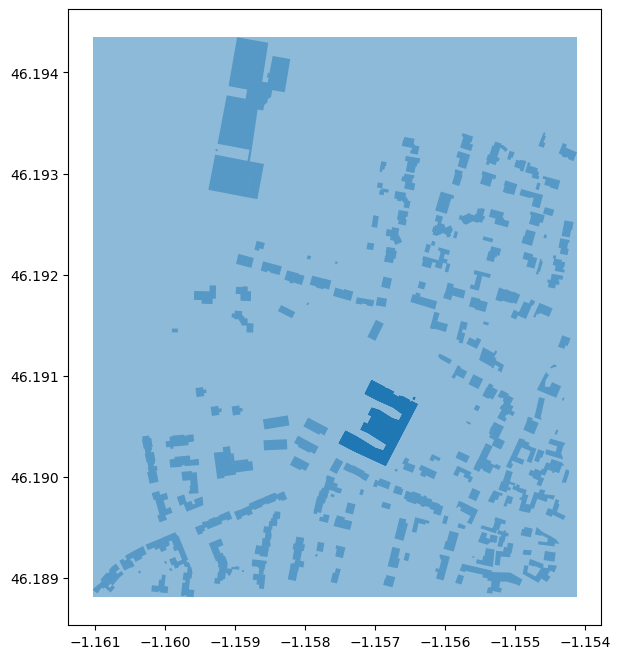

In [11]:
# Tracer la carte
fig, ax = plt.subplots(figsize=(10, 8))
joined_4326.plot(ax = ax, alpha = 0.5)
gpd.GeoDataFrame(gpd.GeoSeries(box(bbox_final[0], 
                                                 bbox_final[1], 
                                                 bbox_final[2], 
                                                 bbox_final[3])), 
                               columns=['geometry'],
                               crs='epsg:4326').plot(ax = ax, alpha = 0.5)

# IV. Construction de la couche `landcover`


In [12]:
from pymdu.geometric.LandCover import LandCover
# pas de végétation environnante ? voir avec COSIA
vegetation_path = os.path.join(input_path, 'vegetations.shp')
vegetation_environnantes = gpd.read_file(vegetation_path).to_crs(2154)

veg1_path = os.path.join(input_path, 'SOL_COPEAUX BOIS.shp')
vegetation_1 = gpd.read_file(veg1_path).to_crs(2154)

veg2_path = os.path.join(input_path,'SOL_ESPACES VERTS.shp')
vegetation_2 = gpd.read_file(veg2_path).to_crs(2154)

veg3_path = os.path.join(input_path,'SOL_STATIONNEMENT VERT.shp')
vegetation_3 = gpd.read_file(veg3_path).to_crs(2154)

joined = pd.concat([vegetation_1, vegetation_2, vegetation_3])

joined.to_file(os.path.join(input_path, 'vegetations.shp'))

In [13]:
water_path = os.path.join(input_path,'SOL_MARE.shp')
water = gpd.read_file(water_path).to_crs(2154)
water.to_file(os.path.join(input_path,'water.shp'))

In [14]:
buildings = gpd.read_file(os.path.join(input_path,'buildings.shp')).to_crs(2154)
vegetations = gpd.read_file(os.path.join(input_path,'vegetations.shp')).to_crs(2154)
water = gpd.read_file(os.path.join(input_path,'water.shp')).to_crs(2154)

In [15]:
from pymdu.commons.BasicFunctions import extract_coordinates_from_filenames, get_intersection_with_bbox, \
    get_intersection_with_bbox_and_attributes
directory_path = os.path.join("D:\\CoSIA_D017_2021\\CoSIA_D017_2021")
gdf_coordinates = extract_coordinates_from_filenames(directory_path)
intersection_gdf = get_intersection_with_bbox(gdf_coordinates, bbox_final)
cosia = get_intersection_with_bbox_and_attributes(gdf_coordinates, bbox_final, directory_path)

In [16]:

landcover = pymdu.geometric.LandCover(output_path=output_path, 
                      building_gdf=buildings, 
                      vegetation_gdf=vegetations, 
                      pedestrian_gdf=None,
                      cosia_gdf=cosia,
                      water_gdf=water)
landcover_gdf = landcover.run(keep_geom_type=True).to_gdf()

landcover.bbox = bbox_final
landcover.to_shp(name='landcover')

    numero            classe  \
0       15           Pelouse   
1       15           Pelouse   
2        3  Zone imperméable   
3       10           Feuillu   
4       10           Feuillu   
..     ...               ...   
95      10           Feuillu   
96      15           Pelouse   
97      15           Pelouse   
98      15           Pelouse   
99      16           Culture   

                                             geometry  
0   POLYGON ((379278.4 6573896.4, 379277.8 6573893...  
1   MULTIPOLYGON (((379248.2 6573897.2, 379249.4 6...  
2   POLYGON ((379249.2 6573894, 379249.2 6573894.2...  
3   POLYGON ((379250 6573900.2, 379248.2 6573898, ...  
4   POLYGON ((379245.8 6573903, 379242.4 6573899.4...  
..                                                ...  
95  POLYGON ((379264.4 6574350.6, 379264.8 6574351...  
96  POLYGON ((379247.8 6574290, 379253.8 6574288, ...  
97  POLYGON ((379352.6 6574331.8, 379354.6 6574333...  
98  POLYGON ((379251.2 6574304.6, 379249.4 6574303...  

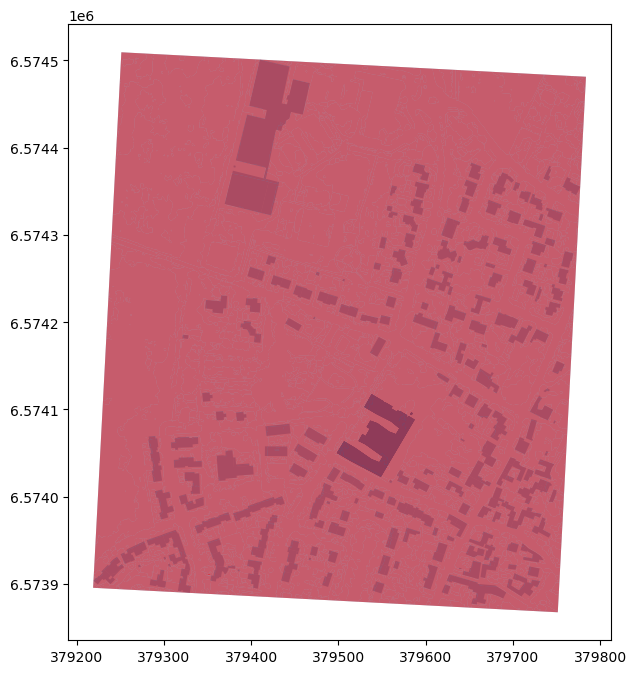

In [17]:
# Tracer la carte
fig, ax = plt.subplots(figsize=(10, 8))
joined_4326.to_crs(2154).plot(ax = ax, alpha = 0.5)
gpd.GeoDataFrame(gpd.GeoSeries(box(bbox_final[0], 
                                                 bbox_final[1], 
                                                 bbox_final[2], 
                                                 bbox_final[3])), 
                               columns=['geometry'],
                               crs='epsg:4326').to_crs(2154).plot(ax = ax, alpha = 0.5)
landcover.gdf.plot(ax = ax, color = 'r', alpha = 0.5)

# Si COSIA est utilisé
landcover.create_landcover_from_cosia(os.path.join(input_path, "landcover.tif"))

# # Si COSIA n'est pas utilisé
# from pymdu.image.geotiff import gdf_to_raster
# gdf_to_raster(
#     dst_tif=os.path.join(input_path, "landcover.tif"),
#     gdf=landcover_gdf, 
#     measurement="umep_keys", 
#     resolution=(-1, 1), 
#     raster_file_like=None, 
#     fill_value=None,
#     dtype='float64')

In [18]:
landcover_gdf

,numero,classe,geometry
0,15,Pelouse,"POLYGON ((379278.4 6573896.4, 379277.8 6573893..."
1,15,Pelouse,"MULTIPOLYGON (((379248.2 6573897.2, 379249.4 6..."
2,3,Zone imperméable,"POLYGON ((379249.2 6573894, 379249.2 6573894.2..."
3,10,Feuillu,"POLYGON ((379250 6573900.2, 379248.2 6573898, ..."
4,10,Feuillu,"POLYGON ((379245.8 6573903, 379242.4 6573899.4..."
...,...,...,...
3354,15,Pelouse,"MULTIPOLYGON (((379774.6 6574481.4, 379774.6 6..."
3355,10,Feuillu,"POLYGON ((379733.6 6574475, 379733.8 6574475, ..."
3356,2,Zone perméable,"POLYGON ((379735.2 6574473.4, 379733.8 6574475..."
3357,15,Pelouse,"MULTIPOLYGON (((379734.6 6574479.2, 379734.6 6..."


# V. Création de la couche `DEM`: Digital Elevation Model

In [19]:
dem = pymdu.geometric.Dem(output_path=input_path)
dem.bbox = bbox_final
dem.run()

bbox_final_1 = box(bbox_final[0], bbox_final[1], bbox_final[2], bbox_final[3])
gdf_bbox_mask_4326= gpd.GeoDataFrame(
    gpd.GeoSeries(bbox_final_1), columns=["geometry"], crs="epsg:4326"
)
gdf_bbox_mask_2154=gdf_bbox_mask_4326.to_crs(epsg=2154)
gdf_bbox_mask_2154.to_file(
    os.path.join(output_path,"mask.shp"), driver="ESRI Shapefile"
)

inraster = os.path.join(input_path, "DEM.tif")
outraster = os.path.join(output_path,"DEM.tif")
inshape = os.path.join(output_path,"mask.shp")
subprocess.call(['gdalwarp', inraster, outraster, '-cutline', inshape, 
                     '-crop_to_cutline', '-overwrite',  '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot', 'Float32'])

Index(['Service', 'Thï¿½matique', 'Producteur', 'Nom',
       'URL d'acces Geoportail', 'URL d'acces Geoplateforme',
       'Statut de licence', 'Etat de publication', 'Statut  Gï¿½oplateforme',
       'Date actualisation de la donnï¿½e', 'Remarque'],
      dtype='object')
key=> dem
['ELEVATION.ELEVATIONGRIDCOVERAGE.HIGHRES'
 'ELEVATION.ELEVATIONGRIDCOVERAGE.HIGHRES']
https://data.geopf.fr/wms-r/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetCapabilities
URL  :  C:\Users\simon\AppData\Local\Temp\dem.tiff


0

In [20]:
gdal.AllRegister()

inraster = os.path.join(input_path,"landcover.tif")
outraster = os.path.join(output_path,"landcover.tif")
inshape = os.path.join(output_path,"mask.shp")

subprocess.call(['gdalwarp', inraster, outraster, '-cutline', inshape, 
                    '-crop_to_cutline', '-overwrite',  '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot', 'Float32'])

0

In [21]:
from pymdu.image.geotiff import raster_file_like
gdal.AllRegister()
warp_options = gdal.WarpOptions(format='GTiff',  # width=width,
                    # height=height,
                    xRes=1, yRes=1, outputType=gdalconst.GDT_Float32, dstNodata=None,
                    dstSRS='EPSG:2154', cropToCutline=True,
                    cutlineDSName=os.path.join(output_path, 'mask.shp'),
                    cutlineLayer='mask')

gdal.Warp(destNameOrDestDS=os.path.join(output_path, 'landcover_clip.tif'),
              srcDSOrSrcDSTab=os.path.join(input_path,'landcover.tif'),
              options=warp_options)

raster_file_like(dst_tif=os.path.join(output_path, "landcover.tif"),
                         src_tif=os.path.join(output_path, "landcover_clip.tif"),
                         like_path=os.path.join(input_path, "DEM.tif"), remove_nan=True)

Pas besoin de re-découper


<xarray.DataArray (band: 1, y: 642, x: 565)> Size: 1MB
array([[[1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.],
        ...,
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]]], dtype=float32)
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 5kB 3.792e+05 3.792e+05 ... 3.798e+05 3.798e+05
  * y            (y) float64 5kB 6.575e+06 6.575e+06 ... 6.574e+06 6.574e+06
    spatial_ref  int32 4B 0
Attributes:
    long_name:      type
    name:           type
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [22]:
import rasterio
def get_dem_bounds(dem_file):
    """
    Extrait les coordonnées d'emprise (bounding box) et le code EPSG du fichier DEM.

    Paramètres :
    - dem_file (str) : Chemin du fichier DEM au format GeoTIFF (.tif).

    Retour :
    - str : Chaîne de caractères contenant les coordonnées avec 9 décimales et le code EPSG.
    """
    with rasterio.open(dem_file) as dataset:
        bounds = dataset.bounds  # (left, bottom, right, top)
        crs = dataset.crs
        epsg_code = crs.to_epsg() if crs else "Unknown"

        # Formatage du résultat avec 9 décimales
        return f"{bounds.left:.4f}00000,{bounds.right:.4f}00000,{bounds.bottom:.4f}00000,{bounds.top:.4f}00000 [EPSG:{epsg_code}]"
# Exemple d'utilisation
dem_path = os.path.join(output_path, "DEM.tif")
result = get_dem_bounds(dem_path)
print(result)


379218.780300000,379783.780300000,6573867.270700000,6574509.270700000 [EPSG:2154]


# VI. Construction de la couche `DSM`



```
processing.run("umep:Spatial Data: DSM Generator", 
{'INPUT_DEM':'C:/Users/simon/python-scripts/EcoleDeLagord/results/DEM.tif',
'INPUT_POLYGONLAYER':'C:/Users/simon/python-scripts/EcoleDeLagord/example/buildings.shp',
'INPUT_FIELD':'hauteur',
'USE_OSM':False,
'BUILDING_LEVEL':3.1,
'EXTENT':'379218.780300000,379783.780300000,6573867.270700000,6574509.270700000 [EPSG:2154]',
'PIXEL_RESOLUTION':1,
'OUTPUT_DSM':'C:/Users/simon/python-scripts/EcoleDeLagord/results/DSM.tif'})
```
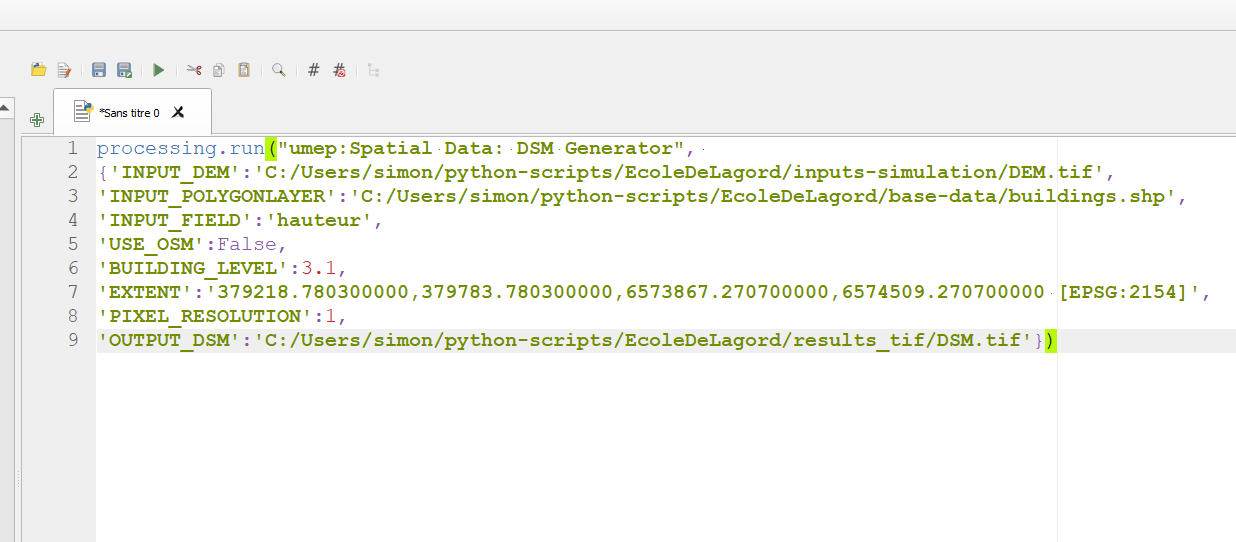



In [23]:
inraster = os.path.join(output_path,f"DSM.tif")
outraster = os.path.join(output_path,f"DSM.tif")
inshape = os.path.join(output_path,"mask.shp")

subprocess.call(['gdalwarp', inraster, 
                 outraster, '-cutline', 
                 inshape, 
                '-crop_to_cutline', 
                 '-overwrite',  
                 '-of', 
                 'GTIFF',
                 '-t_srs', 
                 'EPSG:2154', '-tr', '1', '1', '-ot', 'Float32'])

1

# VII. Construction de la couche `CDSM` et `TDSM`


```
processing.run("umep:Spatial Data: Tree Generator", 
{'INPUT_POINTLAYER':'C:/Users/simon/python-scripts/EcoleDeLagord/example/trees.shp',
'TREE_TYPE':'type',
'TOT_HEIGHT':'height',
'TRUNK_HEIGHT':'trunk_zone',
'DIA':'diameter',
'INPUT_BUILD':None,
'INPUT_DSM':'C:/Users/simon/python-scripts/EcoleDeLagord/results/DSM.tif',
'INPUT_DEM':'C:/Users/simon/python-scripts/EcoleDeLagord/results/DEM.tif',
'INPUT_CDSM':None,
'INPUT_TDSM':None,
'CDSM_GRID_OUT':'C:/Users/simon/python-scripts/EcoleDeLagord/results/CDSM.tif',
'TDSM_GRID_OUT':'C:/Users/simon/python-scripts/EcoleDeLagord/results/TDSM.tif'})
```

In [24]:
list_files = ['CDSM', 'TDSM']
for file in list_files:
    inraster = os.path.join(input_path,f"{file}.tif")
    outraster = os.path.join(output_path,f"{file}.tif")
    inshape = os.path.join(output_path,"mask.shp")
    subprocess.call(['gdalwarp', inraster, outraster, '-cutline', inshape, 
                     '-crop_to_cutline', '-overwrite',  '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot', 'Float32'])

# VIII. Construction de la couche `HEIGHT` et `ASPECT`

```
processing.run("umep:Urban Geometry: Wall Height and Aspect", 
{'INPUT':'C:/Users/simon/python-scripts/EcoleDeLagord/results/DSM.tif',
'INPUT_LIMIT':3,
'OUTPUT_HEIGHT':'C:/Users/simon/python-scripts/EcoleDeLagord/results/HEIGHT.tif',
'OUTPUT_ASPECT':'C:/Users/simon/python-scripts/EcoleDeLagord/results/ASPECT.tif'})
```


In [25]:
list_files = ['HEIGHT', 'ASPECT']
for file in list_files:
    inraster = os.path.join(input_path,f"{file}.tif")
    outraster = os.path.join(output_path,f"{file}.tif")
    inshape = os.path.join(output_path,"mask.shp")

    subprocess.call(['gdalwarp', inraster, outraster, '-cutline', inshape, 
                     '-crop_to_cutline', '-overwrite',  '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot', 'Float32'])

# IX. Construction de la couche `SkyViewFactor`

```
processing.run("umep:Urban Geometry: Sky View Factor",
{'INPUT_DSM':'C:/Users/simon/python-scripts/EcoleDeLagord/results/DSM.tif',
'INPUT_CDSM':'C:/Users/simon/python-scripts/EcoleDeLagord/results/CDSM.tif',
'TRANS_VEG':3,
'INPUT_TDSM':'C:/Users/simon/python-scripts/EcoleDeLagord/results/TDSM.tif',
'INPUT_THEIGHT':25,
'ANISO':True,
'OUTPUT_DIR':'C:/Users/simon/python-scripts/EcoleDeLagord/results',
'OUTPUT_FILE':'C:/Users/simon/python-scripts/EcoleDeLagord/results/SVF.tif'})
```

In [26]:
output_path

'C:\\Users\\simon\\python-scripts\\EcoleDeLagord\\results'

In [27]:
inraster = os.path.join(output_path,"SVF.tif")
outraster = os.path.join(output_path,"SVF_clip.tif")
inshape = os.path.join(output_path,"mask.shp")

subprocess.call(['gdalwarp', inraster, outraster, '-cutline', inshape, 
                     '-crop_to_cutline', '-overwrite',  '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot', 'Float32'])

0

# X. Construction du fichier météo


In [28]:
from epw import epw
WEATHER_FILE = os.path.join(input_path, 'FRA_AC_La.Rochelle.Intl.AP.073160_TMYx.epw')
a=epw()
a.read(WEATHER_FILE)
df=a.dataframe 
df.index = pd.date_range(start = '2023-01-01 00:00:00',freq = '1h', periods = len(df))
meteo_test = pymdu.meteo.Meteo(output_path=input_path)
meteo_test.bbox = bbox_final
meteo_test.run(begin='2023-06-30 11:00:00', end='2023-06-30 14:00:00')
meteo_path = glob.glob(os.path.join(input_path, '*.txt'))

# https://raw.githubusercontent.com/rupeelab17/epw-data/refs/heads/main/france/FRA_AC_La.Rochelle.073150_TMYx.2004-2018.epw

WEATHERFILE_PATH FOUND FRA_AC_La.Rochelle.Intl.AP.073160_TMYx.2004-2018.epw
                     Year  Month  Day  Hour  Minute  \
2023-06-30 11:00:00  2015      6   30    12      60   
2023-06-30 12:00:00  2015      6   30    13      60   
2023-06-30 13:00:00  2015      6   30    14      60   
2023-06-30 14:00:00  2015      6   30    15      60   

                                Data Source and Uncertainty Flags  \
2023-06-30 11:00:00  ?9?9?9?9E0?9?9?9*9*9?9?9?9?9?9?9*9*9*9*9*9*9   
2023-06-30 12:00:00  ?9?9?9?9E0?9?9?9*9*9?9?9?9?9?9?9*9*9*9*9*9*9   
2023-06-30 13:00:00  ?9?9?9?9E0?9?9?9*9*9?9?9?9?9?9?9*9*9*9*9*9*9   
2023-06-30 14:00:00  ?9?9?9?9E0?9?9?9*9*9?9?9?9?9?9?9*9*9*9*9*9*9   

                     Dry Bulb Temperature  Dew Point Temperature  \
2023-06-30 11:00:00                  34.5                   13.3   
2023-06-30 12:00:00                  36.0                   12.9   
2023-06-30 13:00:00                  37.2                   11.9   
2023-06-30 14:00:00           

# XI. Simulation `SOLWEIG`

```

processing.run("umep:Outdoor Thermal Comfort: SOLWEIG", {
'INPUT_DSM':'C:/Users/simon/python-scripts/EcoleDeLagord/results/DSM.tif',
'INPUT_SVF':'C:\\Users\\simon\\python-scripts\\EcoleDeLagord\\results\\svfs.zip',
'INPUT_HEIGHT':'C:/Users/simon/python-scripts/EcoleDeLagord/results/HEIGHT.tif',
'INPUT_ASPECT':'C:/Users/simon/python-scripts/EcoleDeLagord/results/ASPECT.tif',
'INPUT_CDSM':'C:/Users/simon/python-scripts/EcoleDeLagord/results/CDSM.tif',
'TRANS_VEG':3,'LEAF_START':97,
'LEAF_END':300,
'CONIFER_TREES':False,
'INPUT_TDSM':'C:/Users/simon/python-scripts/EcoleDeLagord/results/TDSM.tif',
'INPUT_THEIGHT':25,
'INPUT_LC':'C:/Users/simon/python-scripts/EcoleDeLagord/results/landcover.tif',
'USE_LC_BUILD':False,
'INPUT_DEM':'C:/Users/simon/python-scripts/EcoleDeLagord/results/DEM.tif',
'SAVE_BUILD':False,
'INPUT_ANISO':'',
'ALBEDO_WALLS':0.2,
'ALBEDO_GROUND':0.15,
'EMIS_WALLS':0.9,
'EMIS_GROUND':0.95,
'ABS_S':0.7,
'ABS_L':0.95,
'POSTURE':0,
'CYL':True,
'INPUTMET':'C:\\Users\\simon\\python-scripts\\EcoleDeLagord\\example\\FRA_AC_La.Rochelle.Intl.AP.073160_TMYx.2004-2018.txt',
'ONLYGLOBAL':False,'UTC':0,
'POI_FILE':None,
'POI_FIELD':'',
'AGE':35,
'ACTIVITY':80,
'CLO':0.9,
'WEIGHT':75,
'HEIGHT':180,
'SEX':0,
'SENSOR_HEIGHT':10,
'OUTPUT_TMRT':True,'OUTPUT_KDOWN':False,
'OUTPUT_KUP':False,'OUTPUT_LDOWN':False,
'OUTPUT_LUP':False,'OUTPUT_SH':False,
'OUTPUT_TREEPLANTER':False,'OUTPUT_DIR':'C:\\Users\\simon\\python-scripts\\EcoleDeLagord\\results'})
```

# XII. Génération des arbres pour U-rock

In [29]:
arbres = gpd.read_file(os.path.join(input_path, 'trees.shp'))
# arbres = gpd.clip(arbres, gdf_bbox_mask)

In [30]:
batiments = gpd.read_file(os.path.join(input_path, 'buildings.shp'))

In [31]:
from pymdu.geometric.UrockFiles import UrockFiles
urock = UrockFiles(output_path,batiments, arbres)
urock.generate_urock_buildings().to_file(os.path.join(input_path, 'batiments_urock.shp'), driver="ESRI Shapefile")
urock.generate_urock_trees().to_file(os.path.join(input_path, 'arbres_urock.shp'), driver="ESRI Shapefile")

# XIII. Lancement de `Urock`

```
processing.run("umep:Urban Wind Field: URock", {
'BUILDINGS':'C:/Users/simon/python-scripts/EcoleDeLagord/example/batiments_urock.shp',
'HEIGHT_FIELD_BUILD':'hauteur',
'VEGETATION':'C:/Users/simon/python-scripts/EcoleDeLagord/example/arbres_urock.shp',
'VEGETATION_CROWN_TOP_HEIGHT':'MAX_HEIGHT',
'VEGETATION_CROWN_BASE_HEIGHT':'MIN_HEIGHT',
'ATTENUATION_FIELD':'ATTENUATIO',
'INPUT_PROFILE_FILE':'',
'INPUT_PROFILE_TYPE':0,
'INPUT_WIND_HEIGHT':10,
'INPUT_WIND_SPEED':1,
'INPUT_WIND_DIRECTION':45,
'RASTER_OUTPUT':None,
'HORIZONTAL_RESOLUTION':2,
'VERTICAL_RESOLUTION':2,
'WIND_HEIGHT':'1.5',
'UROCK_OUTPUT':'C:\\Users\\simon\\python-scripts\\EcoleDeLagord\\results',
'OUTPUT_FILENAME':'urock_output',
'SAVE_RASTER':True,
'SAVE_VECTOR':True,
'SAVE_NETCDF':False,
'LOAD_OUTPUT':False})
```


# XIV. Projection du fichier `Urock`

In [32]:
import glob
import pandas as pd
from pymdu.image.geotiff import reproject_resample_cropped_raster

MODEL_FILE = glob.glob(os.path.join(output_path,"Tmrt*.tif"))[0]
INPUT_FILE = os.path.join(output_path,'z1_5', f'urock_outputWS.Gtiff')
    
    
direction = INPUT_FILE.split('WS.Gtiff')[0].split('output_')[-1]
print(direction)
OUTPUT_FILE = os.path.join(output_path, f"{direction}.tif")
reproject_resample_cropped_raster(MODEL_FILE, INPUT_FILE, dst_tif = OUTPUT_FILE)

C:\Users\simon\python-scripts\EcoleDeLagord\results\z1_5\urock_output
C:\Users\simon\micromamba\envs\pymdu\Lib\site-packages\osgeo\gdal.py


In [33]:
MODEL_FILE

'C:\\Users\\simon\\python-scripts\\EcoleDeLagord\\results\\Tmrt_2023_181_1260D.tif'

# XV. Lecture d'un raster de Tmrt

In [34]:
import rioxarray
TMRT_PATH = glob.glob(os.path.join(output_path,"Tmrt*1260D.tif"))[0]

In [35]:
print(TMRT_PATH)

C:\Users\simon\python-scripts\EcoleDeLagord\results\Tmrt_2023_181_1260D.tif


# XVI. Lecture d'un raster de Wind

In [36]:
WIND_PATH = os.path.join(output_path, "z1_5", f'urock_output.tif')
WIND_dataset = rioxarray.open_rasterio(WIND_PATH)

In [37]:
WIND_dataset

<xarray.DataArray (band: 1, y: 642, x: 565)> Size: 3MB
[362730 values with dtype=float64]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 5kB 3.792e+05 3.792e+05 ... 3.798e+05 3.798e+05
  * y            (y) float64 5kB 6.575e+06 6.575e+06 ... 6.574e+06 6.574e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

# XVII. Calcul d'un raster d'UTCI
`TODO : améliorer la msie en forme + lier au fichier météo`

In [38]:
from tqdm import tqdm
import numpy as np
TMRT_dataset = rioxarray.open_rasterio(TMRT_PATH)
WIND_dataset = 10*rioxarray.open_rasterio(WIND_PATH)

from pythermalcomfort.models import utci
UTCI_dataset = TMRT_dataset.copy()
tmr_as_array = TMRT_dataset.data[0]
wind_as_array = WIND_dataset.data[0]
size1, size2 = tmr_as_array.shape
output = np.zeros(shape=(size1, size2))
tdb = 24
rh = 50
for i in tqdm(range(0, size1)):
    output[i, :] = utci(tdb=tdb, tr=tmr_as_array[i, :], v=wind_as_array[i, :], rh=rh,
                        limit_inputs=False)
UTCI_dataset.data[0] = output

100%|██████████████████████████████████████████████████████████████████████████████| 642/642 [00:00<00:00, 9654.94it/s]


In [39]:
tmr_as_array

array([[67.49671 , 67.49671 , 67.49671 , ..., 67.18908 , 67.20734 ,
        67.16758 ],
       [67.55894 , 67.55894 , 67.55894 , ..., 67.14087 , 67.159134,
        67.17739 ],
       [67.55894 , 67.55894 , 67.55894 , ..., 67.08607 , 67.10434 ,
        67.122604],
       ...,
       [67.93453 , 67.93453 , 67.93453 , ..., 67.747116, 67.747116,
        67.747116],
       [67.93453 , 67.93453 , 67.93453 , ..., 67.74198 , 67.74198 ,
        67.68612 ],
       [67.88297 , 67.88297 , 67.88297 , ..., 67.72668 , 67.72668 ,
        67.671295]], dtype=float32)

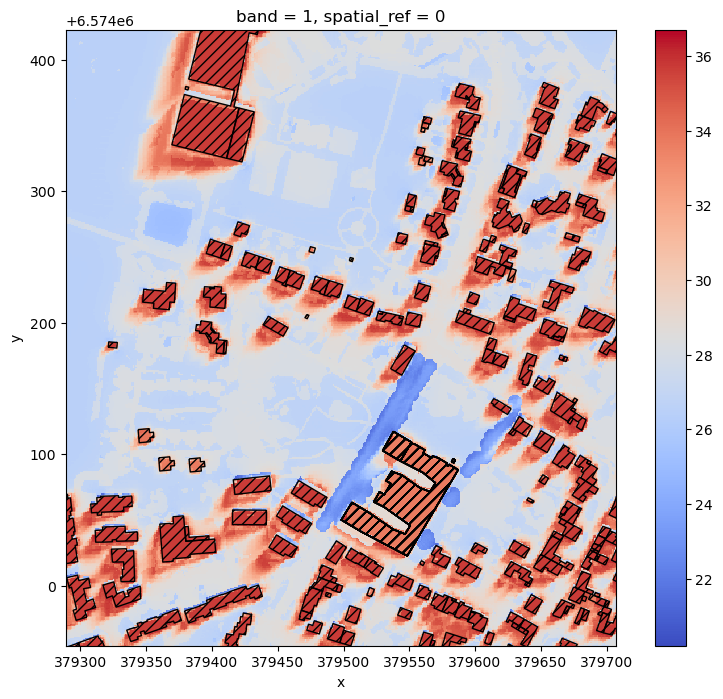

In [40]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
# Charger les données
batiments = gpd.read_file(os.path.join(input_path, 'buildings.shp'))

xmin, ymin, xmax, ymax = batiments.total_bounds
zoom_factor = 0.75  # Ajuster ce facteur pour un zoom plus ou moins fort

xcenter = (xmin + xmax) / 2
ycenter = (ymin + ymax) / 2

new_xmin = xcenter - (xmax - xmin) * zoom_factor / 2
new_xmax = xcenter + (xmax - xmin) * zoom_factor / 2
new_ymin = ycenter - (ymax - ymin) * zoom_factor / 2
new_ymax = ycenter + (ymax - ymin) * zoom_factor / 2

# Tracer la carte
fig, ax = plt.subplots(figsize=(10, 8))

# Tracer la carte de l'UTCI
UTCI_dataset.plot(ax=ax, cmap='coolwarm', 
                  vmin=UTCI_dataset.data.min(), 
                  vmax=UTCI_dataset.data.max())

# Superposer les bâtiments en hachuré
batiments.plot(ax=ax, edgecolor='black', facecolor='none', hatch='///')


ax.set_xlim(new_xmin, new_xmax)
ax.set_ylim(new_ymin, new_ymax)
# Afficher la carte
plt.show()